# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn import cross_validation

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite')

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be 0 and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [3]:
print(filtered_data.shape) 
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final = sorted_data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1; 

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [12]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'her', 'hasn', 'do', 'hers', 'am', 'each', 'you', 'again', 'shan', 'were', 'ma', 'as', 'very', 'while', 'before', 've', 'once', 'has', 's', 'both', "you'd", 'them', 'out', 'same', 'are', 'couldn', 'under', 'won', 'did', 'below', 'wouldn', 'will', 'we', 'further', 'was', 'more', 'down', "couldn't", 'until', 'what', "you're", "shan't", 'against', "aren't", 'm', 'yourself', 'the', 'to', 'if', "wouldn't", 'so', 're', 'aren', 'my', 'who', 'which', 'why', "don't", 'between', 'having', 'only', "weren't", 'doesn', "mightn't", 't', "should've", 'after', 'then', 'no', 'not', 'shouldn', 'mustn', "you'll", 'weren', 'in', 'its', 'been', 'our', 'where', 'himself', 'ourselves', 'for', 'i', 'does', "that'll", 'above', 'being', 'hadn', "won't", 'is', 'that', "shouldn't", 'other', 'o', 'by', 'needn', 'now', 'me', "wasn't", 'some', 'an', "didn't", 'ain', 'mightn', 'at', 'up', 'your', 'their', 'just', 'when', "doesn't", 'yourselves', 'doing', "isn't", 'ours', 'own', 'his', 'because', 'itself', "hadn't", 

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [14]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [15]:
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


In [16]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [17]:
con = sqlite3.connect("final.sqlite")
cleaned_data = pd.read_sql_query("select * from Reviews", con)

In [18]:
print(cleaned_data.shape)
cleaned_data.head()

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [19]:
cleaned_data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [20]:
# To randomly sample 60k points from both class

random_sample_data = final.sample(n=60000) 
random_sample_data.shape

(60000, 11)

In [21]:
# Sort data based on time
final_sorted_time=random_sample_data.sort_values('Time',ascending=True,axis=0)


In [22]:
final_sorted_time.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,1,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,b'happen say name three time michael keaten st...
138001,149770,B00004S1C5,A1KXONFPU2XQ5K,Stephanie Manley,8,8,1,965779200,Very easy to use,This are so much easier to use than the Wilson...,b'much easier use wilson past color color vibr...
346102,374408,B00004CI84,A1GB1Q193DNFGR,Bruce Lee Pullen,5,5,1,970531200,Fabulous Comedic Fanasy Directed by a Master,Beetlejuice is an awe-inspiring wonderfully am...,b'beetlejuic wonder amus comed romp explor inc...


In [23]:
#data splitting
y_Train=final_sorted_time['Score'][0:42000]
y_train=final_sorted_time['Score'][0:29400]
y_cv=final_sorted_time['Score'][29400:42000]
y_test=final_sorted_time['Score'][42000:60000]

In [24]:
Train_data=final_sorted_time['CleanedText'][0:42000]
train_data=final_sorted_time['CleanedText'][0:29400]
cv_data=final_sorted_time['CleanedText'][29400:42000]
test_data=final_sorted_time['CleanedText'][42000:60000]

# [4] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using absolute values of `coef_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

## [4.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [25]:
count_vector=CountVectorizer()
train_bows=count_vector.fit_transform(train_data)
cv_bows=count_vector.transform(cv_data)

In [38]:
train_bows.shape

(29400, 21709)

In [39]:
cv_bows.shape

(12600, 21709)

In [40]:
y_train.shape

(29400,)

In [42]:
y_cv.shape

(12600,)

In [30]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import math

In [47]:
from sklearn import metrics
#Simple CrossValidation
AUC_training=[]
AUC_cv=[]
ALPHA=[]
alpha=0.00001
while(alpha<1000000):
    ALPHA.append(math.ceil(math.log(alpha,10)))
    clf=MultinomialNB(alpha=alpha)
    clf.fit(train_bows , y_train)
  
  #Training Curve
    y_predict_training=clf.predict_proba(train_bows)[:,1]
    fpr, tpr, thresholds = roc_curve(y_train, y_predict_training)
    AUC_training.append(metrics.auc(fpr, tpr))
    
  
  #CV Curve
    y_predict_cv=clf.predict_proba(cv_bows)[:,1]
    fpr, tpr, thresholds = roc_curve(y_cv, y_predict_cv)
    AUC_cv.append(metrics.auc(fpr, tpr))
    alpha*=10

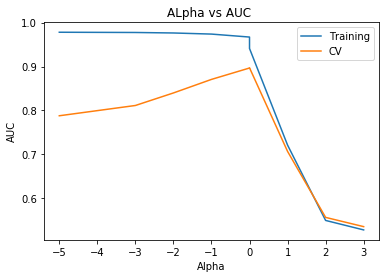

In [48]:
plt.plot(ALPHA[0:9],AUC_training[0:9],label='Training')
plt.plot(ALPHA[0:9],AUC_cv[0:9],label="CV")
plt.ylabel('AUC')
plt.xlabel('Alpha')
plt.title('ALpha vs AUC ')
plt.legend()
plt.show()

Observation: optimal value of Alpha is 1 which is having Auc= 0.89

In [49]:
#For Optimal on test data
count_vectorizer=CountVectorizer()
Train_bows=count_vectorizer.fit_transform(Train_data)
test_bows=count_vectorizer.transform(test_data)

 AUC =  0.9017992576058405


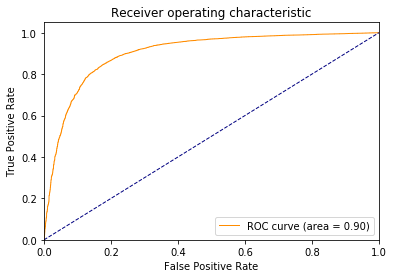




             precision    recall  f1-score   support

          0       0.74      0.59      0.66      3144
          1       0.92      0.96      0.94     14856

avg / total       0.89      0.89      0.89     18000



In [52]:
clf=MultinomialNB(alpha=1.0)
clf.fit(Train_bows,y_Train)
y_pred=clf.predict_proba(test_bows)[:,1]
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
y_pred1=clf.predict(test_bows)
print("\n\n")
print(metrics.classification_report(y_test,y_pred1))

### [4.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [53]:
import operator

In [54]:
feature_names=count_vectorizer.get_feature_names()
a=getattr(clf, 'feature_log_prob_')
top =zip(a[1], feature_names)
top=list(top)
top.sort(key=lambda x: x[0])
l=len(top)
print('\n Top 10 Positive Features:\n')
for i in range(1,11):
    print(top[l-i][1],end="\n")


 Top 10 Positive Features:

like
tast
good
love
flavor
great
use
one
product
tea


### [4.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [55]:
feature_names=count_vectorizer.get_feature_names()
a=getattr(clf, 'feature_log_prob_')
top =zip(a[0], feature_names)
top=list(top)
top.sort(key=lambda x: x[0])
l=len(top)
print('\n Top 10 Negative Features:\n')
for i in range(1,11):
    print(top[l-i][1],end="\n")


 Top 10 Negative Features:

tast
like
product
one
flavor
would
tri
good
use
buy


In [56]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred1)
cm

array([[ 1865,  1279],
       [  665, 14191]], dtype=int64)

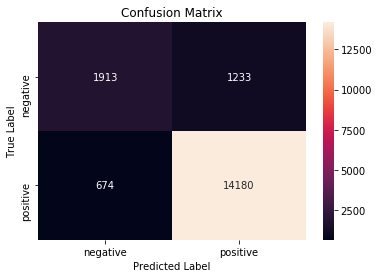

In [111]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## [4.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [57]:
tfidf_vector=TfidfVectorizer()
train_tfidf=tfidf_vector.fit_transform(train_data)
cv_tfidf=tfidf_vector.transform(cv_data)

In [58]:
#Simple CrossValidation
AUC_training=[]
AUC_cv=[]
ALPHA=[]
alpha=0.00001
while(alpha<1000000):
    ALPHA.append(math.ceil(math.log(alpha,10)))
    clf=MultinomialNB(alpha=alpha)
    clf.fit(train_tfidf , y_train)
  
    #Training Curve
    y_predict_training=clf.predict_proba(train_tfidf)[:,1]
    fpr, tpr, thresholds = roc_curve(y_train, y_predict_training)
    AUC_training.append(metrics.auc(fpr, tpr))
 
    #CV Cuve
    y_predict_cv=clf.predict_proba(cv_tfidf)[:,1]
    fpr, tpr, thresholds = roc_curve(y_cv, y_predict_cv)
    AUC_cv.append(metrics.auc(fpr, tpr))
    alpha*=10

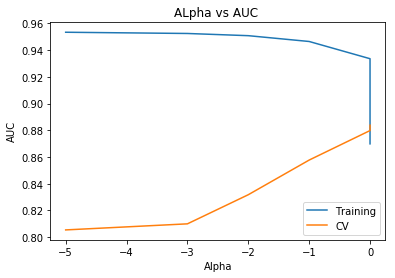

In [114]:
plt.plot(ALPHA[0:9],AUC_training[0:9],label='Training')
plt.plot(ALPHA[0:9],AUC_cv[0:9],label="CV")
plt.ylabel('AUC')
plt.xlabel('Alpha')
plt.title('ALpha vs AUC ')
plt.legend()
plt.show()

Observation: Optimal alpha is 1 having auc= 0.89

In [59]:
#For Optimal on test data
tfidf_vectorizer=TfidfVectorizer()
Train_tfidf=tfidf_vectorizer.fit_transform(Train_data)
test_tfidf=tfidf_vectorizer.transform(test_data)

 AUC =  0.8836216567941124


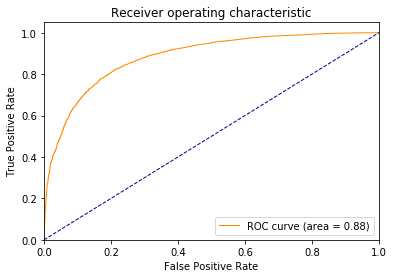




             precision    recall  f1-score   support

          0       0.92      0.02      0.04      3144
          1       0.83      1.00      0.91     14856

avg / total       0.84      0.83      0.75     18000



In [60]:
clf=MultinomialNB(alpha=1.0)
clf.fit(Train_tfidf,y_Train)
y_pred=clf.predict_proba(test_tfidf)[:,1]
y_pred1=clf.predict(test_tfidf)
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print("\n\n")
print(metrics.classification_report(y_test,y_pred1))

### [4.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [61]:
feature_names=tfidf_vectorizer.get_feature_names()
a=getattr(clf, 'feature_log_prob_')
top =zip(a[1], feature_names)
top=list(top)
top.sort(key=lambda x: x[0])
l=len(top)
print('\nTop 1o important Features of Positive class:\n')
for i in range(1,11):
    print(top[l-i][1],end="\n")


Top 1o important Features of Positive class:

great
love
tast
like
good
tea
flavor
coffe
product
use


### [4.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [62]:
feature_names=tfidf_vectorizer.get_feature_names()
a=getattr(clf, 'feature_log_prob_')
top =zip(a[0], feature_names)
top=list(top)
top.sort(key=lambda x: x[0])
l=len(top)
print('\nTop 1o important Features of Negative class:\n')
for i in range(1,11):
    print(top[l-i][1],end="\n")


Top 1o important Features of Negative class:

tast
like
product
would
one
flavor
coffe
buy
tri
order


In [63]:
#from sklearn.matrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred1)
cm

array([[   59,  3085],
       [    5, 14851]], dtype=int64)

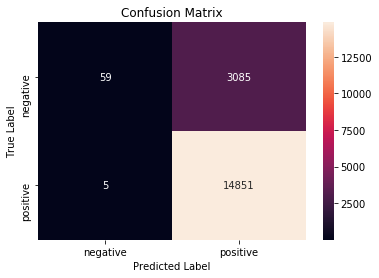

In [64]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# [5] Conclusions

In [66]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Hyper parameter", "AUC"]

x.add_row(["Navie Bayes with BOW", 1, 0.9017992576058405])
x.add_row(["Navie Bayes with TFIDF", 1,metrics.auc(fpr, tpr)])

print(x)

+------------------------+-----------------+--------------------+
|         Model          | Hyper parameter |        AUC         |
+------------------------+-----------------+--------------------+
|  Navie Bayes with BOW  |        1        | 0.9017992576058405 |
| Navie Bayes with TFIDF |        1        | 0.8836216567941124 |
+------------------------+-----------------+--------------------+


From above observatins, both model works pretty good.
As above table states that, Navie Bayes with tfidf works better than bow as it having high auc comparatively.